In [211]:
# %pip install ipympl
# %matplotlib inline
import platform
import os
import ipympl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import bisect
import seaborn as sns
import pickle
from scipy.stats import zscore
from tqdm import tqdm

In [212]:
def init_boc():
    '''
    Initialises and returns the BrainObservatoryCache
    
    Parameters
    ----------
    None
    
    Returns
    -------
    BrainObservatoryCache : allensdk.core.brain_observatory_nwb_data_set.BrainObservatoryNwbDataSet
    '''
    
    # Set file location based on platform. 
    platstring = platform.platform()
    if ('Darwin' in platstring) or ('macOS' in platstring):
        # macOS 
        data_root = "/Volumes/TReND2024/"
    elif 'Windows'  in platstring:
        # Windows (replace with the drive letter of USB drive)
        data_root = "E:/"
    elif ('amzn' in platstring):
        # then on Code Ocean
        data_root = "/data/"
    else:
        # then your own linux platform
        # EDIT location where you mounted hard drive
        data_root = "/media/$USERNAME/TReND2024/"

    from allensdk.core.brain_observatory_cache import BrainObservatoryCache

    manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

    return BrainObservatoryCache(manifest_file=manifest_file)
    

In [213]:
def get_session_ids(cre_line : list, imaging_depths : list, stimuli : list):
    '''
    Get lists of session_ids matching query parameters, grouped by cortical region
    
    Parameters
    ----------
    cre_line :  list
            Array of cre_lines to query
    imaging_depths : list
            Array of imaging_depths to query
    stimuli : list
            Array of stimuli to query
    Returns
    -------
    session_ids : Dictionary
            A Dictionary indexed by targeted_areas, coantaining arrays of matching sessions_ids
    '''
    session_ids = {}
    
    for area in boc.get_all_targeted_structures():
        exps = pd.DataFrame(boc.get_experiment_containers(
            targeted_structures=[area], cre_lines=cre_line, imaging_depths=imaging_depth
        ))
        experiment_container_ids = exps.id.to_numpy()
        sessions = boc.get_ophys_experiments(
            experiment_container_ids=experiment_container_ids, stimuli=stimuli
        )
        
        session_ids[area] = [sessions[i]['id'] for i in range(len(sessions))]
    
    return session_ids

In [214]:
def get_tables(data_set):
    '''
    Return the stimulus table and events table, clipped to the duration of the stimulus
    
    Parameters
    ----------
    data_set : allensdk.core.brain_observatory_nwb_data_set.BrainObservatoryNwbDataSet
    
    Returns
    -------
    stim_table : pandas DataFrame
            Dataframe containing stimulus information for each time step
    events : array_like
            2-D array of event values where events[n,m] is the event of cell n at time m
    '''
    stim_table = data_set.get_stimulus_table('natural_scenes')
    
    stim_start = stim_table.start.min()
    stim_end = stim_table.end.max()+1
    
    events = boc.get_ophys_experiment_events(ophys_experiment_id=session_id)
    events = events[:, stim_start:stim_end]
    
    stim_table.end = stim_table.end - stim_start
    stim_table.start = stim_table.start - stim_start
    
    return stim_table, events

In [215]:
def get_trial_respones(stim_table, events, axis : int = 1):
    '''
    Computes the average event value over the duration of each trial
    
    Parameters
    ----------
    stim_table : pandas DataFrame
            Dataframe containing stimulus information for each time step
    events : array_like
            2-D array of event values where events[n,m] is the event of cell n at time m
    axis : int, optional
            axis across which to average, default is 1
    Returns
    -------
    trial_responses : array_like
            2-D array of average event values where trial_responses[n,m]
            is the average event value of cell n for trial m
    '''
    averaging_indices = stim_table.end.to_numpy()
    cum_events = events.cumsum(axis=1)[:,averaging_indices]
    trial_sums = np.c_[cum_events[:,0] ,np.diff(cum_events, axis=1)]
    trial_responses = trial_sums/(stim_table.end.to_numpy() - stim_table.start.to_numpy() + 1)
    
    return trial_responses

In [216]:
def get_outlier_trials(trial_responses, z_score : float = 3.):
    '''
    Compute outlying trials based on symmetric z-score
    
    Parameters
    ----------
    trial_responses : pandas DataFrame
            Dataframe containing stimulus information for each time step
    z_score : float, optional
            z_score used to determine outliers with |p| > z_score, default is 3.0
    
    Returns
    -------
    outliers : array_like
            1-D array of trial indices corresponding to outliers
    '''
    trial_responses_df = pd.DataFrame(trial_responses.mean(axis=0))
    # Calculate the Z-score for each data point
    z_scores = trial_responses_df.apply(zscore)
    # Identify rows with any outlier (Z-score > 3 or Z-score < -3)
    outliers = (trial_responses_df[(z_scores > z_score) | (z_scores < -z_score)].to_numpy() > 0).nonzero()[0]
    
    return outliers

In [217]:
def get_stimulus_responses(trial_responses, stim_table, group_by : str, outliers = np.empty(0)):
    '''
    Computes the average trial_response for each value of the stimulus
    
    Parameters
    ----------
    trial_responses : pandas DataFrame
            Dataframe containing stimulus information for each time step
    outliers : array_like
            1-D array of trial indices corresponding to outliers, default is empty
    stim_table : pandas DataFrame
            Dataframe containing stimulus information for each time step
    sort_by : str
            Column name in stim_table used for grouping stimulus values for averaging
    Returns
    -------
    stimulus_responses : array_like
            2-D array of average trial_response values where stimulus_responses[n,m]
            is the average trial_response value of cell n stimulus m
    '''
    trial_responses = np.delete(trial_responses, outliers, axis=1)
    
    frames = stim_table[group_by].to_numpy()
    frames = np.delete(frames, outliers)
    
    sorting_indices = np.argsort(frames)
    sorted_events = trial_responses[:,sorting_indices]
    
    num_trials_per_stim = np.fromiter(collections.Counter(np.sort(frames)).values(), dtype=float)
    averaging_indices = num_trials_per_stim.cumsum().astype('int') - 1
    
    cum_trial_responses = sorted_events.cumsum(axis=1)[:,averaging_indices]
    stimulus_responses = np.c_[cum_trial_responses[:,0] ,np.diff(cum_trial_responses, axis=1)]/num_trials_per_stim
    
    return stimulus_responses

In [218]:
def PCA(stimulus_responses):
    '''
    Computes principle components using eigenvalue decomposition
    
    Parameters
    ----------
    stimulus_responses : array_like
            2-D array of average trial_response values where stimulus_responses[n,m]
            is the average trial_response value of cell n stimulus m
                        
    Returns
    -------
    D : array_like
            1_D array of eigenvalues, each repeated according to its multiplicity.
    U : array_like
            The unit eigenvectors, where U[:,n] is the eigenvector corresponding eigenvalue D[n]
    '''
    mu = np.mean(stimulus_responses,axis=0)
    stimulus_responses_centered = stimulus_responses - mu
    cov = np.cov(stimulus_responses_centered.T)
    
    # perform the eigendecomposition of the data covariance
    D, U = np.linalg.eig(cov) # D = vector of eigenvalues, U = eigenvectors matrix

    # make sure the eigenvalues are sorted (in descending order)
    indx = np.argsort(D)[::-1]
    D = D[indx]

    # arrange the eigenvectors according to the magnitude of the eigenvalues
    U = U[:,indx]
    
    return D, U

In [219]:
def get_dimensionality(D : np.ndarray):
    '''
    Computes number of dimensions required to explain required_variance
    
    Parameters
    ----------
    D : array_like
        1_D array of eigenvalues, each repeated according to its multiplicity.
    Returns
    -------
    dimension : float
        Dimension of the system computed according to 
    '''
    D = np.real(D)
    dimension = (D.sum()**2) / (D @ D)
    
    return dimension

In [220]:
boc = init_boc()

In [221]:
# boc.get_all_cre_lines()

In [222]:
cre_line = boc.get_all_cre_lines()[0:2] # 'Cux2-CreERT2', 'Emx1-IRES-Cre''
# cre_line = [boc.get_all_cre_lines()[x] for x in [5,10,12]]
imaging_depth = boc.get_all_imaging_depths() # 175 - 250
stimulus = ['natural_scenes']

In [223]:
session_ids = get_session_ids(cre_line, imaging_depth, stimulus)
session_ids

{'VISal': [562172003,
  638267173,
  561528269,
  503820068,
  504625475,
  501889084,
  556338149,
  506156402,
  562660121,
  560802931,
  563500510,
  567446262,
  636924826,
  502382906,
  507691380,
  512149367,
  511976329,
  568796683,
  501929146,
  557589954],
 'VISam': [652738799,
  570006683,
  568775666,
  569407590,
  710938138,
  557182484,
  571099190,
  707444935,
  709948912,
  594314285,
  569252439,
  567709426,
  570889097,
  569431665],
 'VISl': [548227481,
  699846423,
  557956194,
  506520703,
  529487172,
  583301416,
  567734055,
  505801925,
  649317434,
  575232864,
  589098031,
  507691834,
  562220433,
  509799475,
  552195520,
  561405713,
  502526200,
  501800164,
  507691735],
 'VISp': [501794235,
  500964514,
  524848692,
  545578997,
  595452192,
  703308147,
  501886692,
  501559087,
  526928092,
  502810282,
  528574532,
  660066712,
  596525298,
  712924011,
  541048140,
  510705057,
  501498760,
  510345479,
  503019786,
  540729056,
  561994407,
 

In [224]:
dimensionality = {}
for area in session_ids.keys():
    dimensions = []
    for session_id in tqdm(session_ids[area]):
        data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
        stim_table, events = get_tables(data_set)
        trial_responses = get_trial_respones(stim_table, events)
        outliers = get_outlier_trials(trial_responses)
        stimulus_responses = get_stimulus_responses(trial_responses, stim_table, group_by='frame', outliers=outliers)
        D, U = PCA(stimulus_responses)
        dimension = get_dimensionality(D)
        dimensions.append(dimension)
    dimensionality[area] = dimensions

dimensionality

100%|██████████| 21/21 [01:32<00:00,  4.41s/it]


{'VISal': [2.7780435563691945,
  17.84407235408983,
  1.727538902933199,
  3.054099577575651,
  7.460600956678742,
  4.950152819409146,
  3.759876697543844,
  2.8012346800474925,
  15.426741569844713,
  6.658806119582045,
  16.290462964438632,
  8.683385120308376,
  10.499909100895895,
  4.54148262379335,
  2.4870473479745105,
  5.638009847224083,
  7.899754676012634,
  4.207737803571711,
  4.7153384570469346,
  19.035587282283718],
 'VISam': [5.516522431561201,
  3.6013601039699314,
  4.901741203674521,
  5.188056253369639,
  6.39464968458261,
  1.1773162286592047,
  4.781935571725484,
  3.6371129293654363,
  4.277910402063318,
  3.3995227146780795,
  5.234460455170239,
  2.224162784314317,
  4.870086048993604,
  2.260865039084284],
 'VISl': [5.591127104739221,
  14.975390014319272,
  7.183340054870268,
  3.8654296161397776,
  6.321577179281125,
  3.8348817983452173,
  4.349362514524886,
  3.647124665069673,
  9.438365420248115,
  21.935211505395927,
  3.7965804377621546,
  4.54672457

In [225]:
# # Open a file and use dump() 
# with open('dimensionality_excitatory_2.pkl', 'wb') as file: 
#     # A new file will be created 
#     pickle.dump(dimensionality, file) 

In [226]:
def plot_dimensions_by_region(dimensionality : dict):
    '''
    
    '''
    sns.barplot(dimensionality, errorbar=("se"), capsize=.4, linewidth=2.5,)

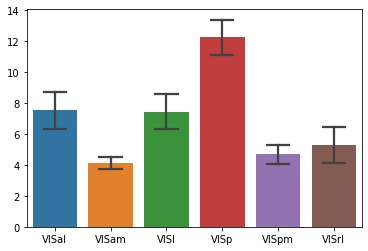

In [227]:
plot_dimensions_by_region(dimensionality)